In [1]:
!pip install pykrx

Defaulting to user installation because normal site-packages is not writeable


# KRX에서 KOSPI 지수, PER, PBR 다운로드 받아서 DB에 저장하기
https://dotsnlines.tistory.com/958

In [5]:
from pykrx import stock
import sqlite3

#df_kos = stock.get_index_fundamental('20000101','20240715', '1001')
df_kos = stock.get_index_fundamental('20030101','20240715', '1001')
con = sqlite3.connect('krx_data.db')
df_kos.to_sql('kospi_index', con=con, if_exists='replace')

print(df_kos)

                 종가   등락률        PER   PBR  배당수익률
날짜                                               
2003-01-02   635.17  1.21  15.800000  1.06   1.75
2003-01-03   661.10  4.08  16.430000  1.10   1.68
2003-01-06   666.71  0.85  16.840000  1.11   1.67
2003-01-07   652.20 -2.18  16.469999  1.09   1.71
2003-01-08   651.72 -0.07  16.459999  1.09   1.71
...             ...   ...        ...   ...    ...
2024-07-09  2867.38  0.34  19.230000  1.03   1.73
2024-07-10  2867.99  0.02  19.240000  1.03   1.73
2024-07-11  2891.35  0.81  19.400000  1.03   1.72
2024-07-12  2857.00 -1.19  19.180000  1.02   1.74
2024-07-15  2860.92  0.14  19.209999  1.03   1.74

[5324 rows x 5 columns]


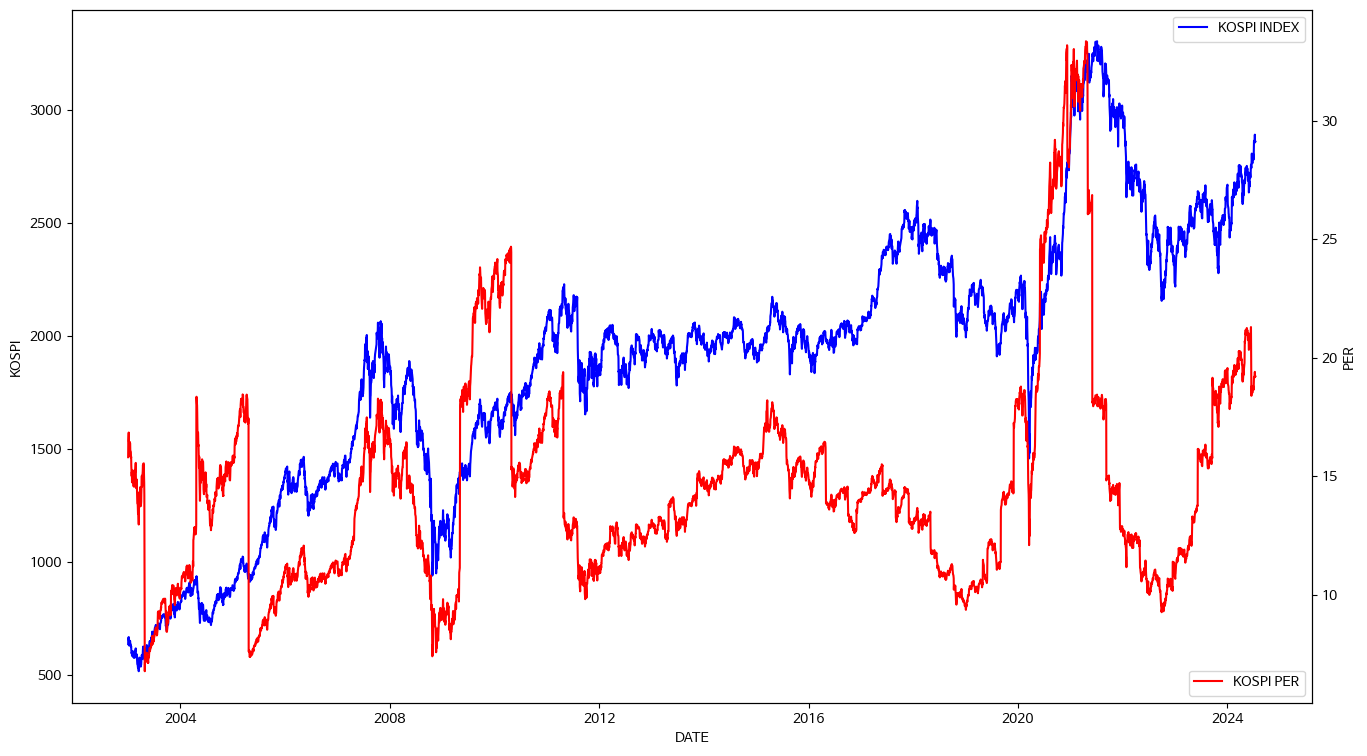

In [6]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

con = sqlite3.connect("krx_data.db")
df_kos = pd.read_sql("SELECT 날짜, 종가, 등락률, PER, PBR FROM kospi_index", con)

df_kos['날짜'] = pd.to_datetime(df_kos['날짜'])
# df_kos['날짜'] = df_kos['날짜'].dt.strftime('%Y%m%d')
df_kos = df_kos.set_index('날짜')

plt.rcParams['figure.figsize'] = (16, 9)

fig, ax1 = plt.subplots()
ax1.set_xlabel('DATE')
ax1.set_ylabel('KOSPI')
ax1.plot(df_kos.index, df_kos['종가'], color='blue', label='KOSPI INDEX')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.set_ylabel('PER')
ax2.plot(df_kos.index, df_kos['PER'], color='red', label='KOSPI PER')
ax2.legend(loc='lower right')

plt.show()

# KRX에서 영업일 다운로드 받기
https://dotsnlines.tistory.com/956

In [ ]:
from pykrx import stock
from datetime import datetime, timedelta
import pandas as pd
import time
import sqlite3
import random
 
# 영업일을 List로 가져오기
def make_date_list(start, end):
    start = datetime.strptime(start, '%Y%m%d')
    end = datetime.strptime(end, '%Y%m%d')
    dates = [(start + timedelta(days=i)).strftime('%Y%m%d') for i in range((end-start).days+1)]
    b_dates = []
    for d in dates:
        b_day = stock.get_nearest_business_day_in_a_week(d)
        print(b_day)
        b_dates.append(b_day)
        s = random.randint(1, 3)
        time.sleep(s)
 
    b_dates = list(dict.fromkeys(b_dates))
    df = pd.DataFrame(data=b_dates, columns=['일자'])
    con = sqlite3.connect('krx_data.db')
    df.to_sql('dates', con, if_exists='append')
 
 
try:
    make_date_list('20190105', '20240716')
except:
    pass

# KRX에서 재무 데이터 DB로 저장하기
https://dotsnlines.tistory.com/957

In [ ]:
from pykrx import stock
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import time
import sqlite3
 
# 영업일을 List로 가져오기
con = sqlite3.connect('krx_data.db')
df = pd.read_sql("SELECT * FROM dates", con)
dates = df['일자'].to_list()
print(dates)
 
def data_download(date):
    codes = stock.get_market_ticker_list(date, market='ALL') # code list 만들기
    corp = [] #Code와 Name을 저장할 List
    for code in codes:
        name = stock.get_market_ticker_name(code) #종목 이름 가져오기
        corp.append([code, name]) #Code와 이름으로 리스트를 만들기
    df1 = pd.DataFrame(data=corp, columns=['code', '종목명'])#code와 종목명을 데이터프레임으로 만들기
    df1.index = df1['code'] #index를 코드로 만들기
 
 
    df_f = stock.get_market_fundamental_by_ticker(date=date, market='ALL')#BPS, PER, PBR, EPS, DIV, DPS 가져와서 데이터 프레임 만들기
    df_c = stock.get_market_cap_by_ticker(date=date, market='ALL')#종가, 시가총액, 거래량, 거래대금, 상장주식수 가져오기
 
    time.sleep(1)
 
    df = pd.merge(df1, df_c, left_index=True, right_index=True) #종목명, 종가, 시가총액, 거래량, 거래대금, 상장주식수
    df = pd.merge(df, df_f, left_index=True, right_index=True) #위에 df + PER, PBR...
    #column은 '종목명', '종가', '시가총액', '거래량', '거래대금', '상장주식수', 'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'
 
    df['일자'] = np.array([date]*len(df))
    df = df.set_index('일자')
 
    return df
 
# 데이터 받아서 데이터프레임으로 합치고, DB에 저장
try:
    for n, date in enumerate(dates):
        print(date)
        if n == 0:
            t_df = data_download(date)
        else:
            t_df = pd.concat([t_df, data_download(date)])
        time.sleep(1) #혹시나 차단될 수 있으니깐
    print(t_df)
    con = sqlite3.connect("krx_data.db")
    t_df.to_sql('fundamental', con, if_exists='append')
except:
    pass

# 퀀트투자 백테스트 코드 (저 PBR * 저DPS)
https://dotsnlines.tistory.com/886

In [7]:
from pykrx import stock
import pandas as pd
import numpy as np
import os
import time
 
# 백테스트 할 날짜를 생성하기
def make_date_list(m, d):
    date_list = []
    for y in range(2010, 2023):
        day = str(y) + str(m) + str(d)
        b_day = stock.get_nearest_business_day_in_a_week(date=day) #휴일이면 근처의 영업일로 변경
        date_list.append(b_day)
    return date_list
 
 
# 연도별 수익률 구하기
def row_pbr_dps(date, date2):
    codes = stock.get_market_ticker_list(date, market='ALL')
    corp = []
    for code in codes:
        name = stock.get_market_ticker_name(code)
        corp.append([code, name])
    df1 = pd.DataFrame(data=corp, columns=['code', '종목명'])
    df1 = df1.set_index('code')
 
    df_f = stock.get_market_fundamental_by_ticker(date=date, market='ALL')  # PER, PBR, DIV,... : KRX 우선가져오기
    df_c = stock.get_market_cap_by_ticker(date=date, market='ALL')  # 종가
 
    df_c2 = stock.get_market_cap_by_ticker(date2, market='ALL')  # 1년 후 종가
 
    time.sleep(1)
 
    df_c2 = df_c2[['종가', '상장주식수']]
 
    df = pd.merge(df1, df_c, left_index=True, right_index=True)
    df = pd.merge(df, df_f, left_index=True, right_index=True)
    df = pd.merge(df, df_c2, left_index=True, right_index=True)
 
    df = df[['종목명', '종가_x', '상장주식수_x', 'PBR', 'DPS', '종가_y', '상장주식수_y', '거래량']]
    df.columns = ['종목명', '종가', '상장주식수', 'PBR', 'DPS', '1년후종가', '1년후상장주식수', '거래량']
    df['상장주식수변동'] = df['1년후상장주식수'] - df['상장주식수']
 
    df = df[df['PBR'] > 0]  # PBR 0이상만 구하기
    df['pbr_rank'] = df['PBR'].rank()
 
    df = df[df['DPS'] > 0]
    df['dps_rank'] = df['DPS'].rank()
 
    df['pbr_dps'] = df['pbr_rank'] + df['dps_rank']
    df['pbr_dps_rank'] = df['pbr_dps'].rank()
    df = df.sort_values(by='pbr_dps_rank')
 
    df = df[df['거래량'] > 0]  # 거래량이 0 이상인 종목만 구하기
 
    df = df.iloc[:30]  # 종목개수
    df['수익'] = df['1년후종가'] - df['종가']
 
    df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
 
    df['수익률'] = (df['수익'] / df['종가'])
    df['투자년도'] = np.array([date] * len(df))
 
    p = df['수익률'].mean()
 
    result = []
    result.append([date, date2, p])
 
    df_t = pd.DataFrame(data=result, columns=['투자일', '1년후', '수익률'])
    return df, df_t
 
# 투자 시작년도부터 마직막 년도까지 반복
def inverst_years(date_list):
    for n in range(len(date_list)):
        if n < len(date_list)-1:
            date = date_list[n]
            date2 = date_list[n+1]
 
            if n == 0:
                df_t = row_pbr_dps(date, date2)[1]
                df = row_pbr_dps(date, date2)[0]
 
            else:
                df_t = pd.concat([df_t, row_pbr_dps(date, date2)[1]])
                df = pd.concat([df, row_pbr_dps(date, date2)[0]])
 
    path2 = origin_path + folder_name + '\\저PBR_DPS(' + m + '월' + d + '일)_거래량 0이상_30개_All Market.xlsx'
    df.to_excel(path2)
    return df_t
    print(df_t)
 
test_days = ['4', '27'] # 매월 매수/매도일
 
for d in test_days:
    origin_path = 'C:\\Users\\김현철\\Desktop'
    folder_name = '\\PBR_DPS백테스트(매월' + d + '일)거래량 0이상(30개)_All Market'
    os.mkdir(origin_path + folder_name)
 
    # 월별로 테스트를 반복하여 결과 얻기
    for m in range(12):
        if m == 0:
            m = '01'
            # 연도별 날짜 List 만들기
            date_list = make_date_list(m, d)
 
            # 백테스트 구동하기
            df_t = inverst_years(date_list)
 
        else:
            m += 1
            m = '0' + str(m)
            m = m[-2:]
            print(m)
 
            #연도별 날짜 List 만들기
            date_list = make_date_list(m, d)
 
            #백테스트 구동하기
            df_t = pd.concat([df_t, inverst_years(date_list)])
 
 
    path = origin_path + folder_name + '\\저PBR_DPS 백테스트(종합 매월'+ d + '일 투자) 거래량 0이상 30개.xlsx'
    df_t.to_excel(path)
 

C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1296.           39.1066776]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

02


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1214.          648.8150507]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

03


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1754.           975.29435652]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

04


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-2251.6          515.32167505]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

05


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

06


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

07


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

08


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

09


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

10


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

11


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

12


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

02


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1761.5          648.00095425]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

03


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1916.8          828.57806084]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

04


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-2929.7          718.89700626]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

05


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

06


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

07


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

08


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

09


C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['수익'].loc[df['상장주식수변동'] < 0] = df['1년후종가'] * (1 + df['상장주식수변동'] / df['상장주식수']) - df['종가']
C:\Users\김현철\AppData\Local\Temp\ipykernel_10596\914201967.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

KeyboardInterrupt: 

# 퀀트투자 종목 스크리닝
https://dotsnlines.tistory.com/887

In [ ]:
from pykrx import stock
import pandas as pd
import numpy as np
 
def make_pbr_dps_list(date):
    codes = stock.get_market_ticker_list(date, market='ALL')
    corp = []
    for code in codes:
        name = stock.get_market_ticker_name(code)
        corp.append([code, name])
    df = pd.DataFrame(data=corp, columns=['code', '종목명'])
    df = df.set_index('code')
 
    df_f = stock.get_market_fundamental_by_ticker(date, market='ALL')
    df_c = stock.get_market_cap_by_ticker(date, market='ALL')
 
    df = pd.merge(df, df_f, left_index=True, right_index=True)
    df = pd.merge(df, df_c, left_index=True, right_index=True)
 
    df = df[df['PBR']>0]
    df['pbr_rank'] = df['PBR'].rank()
 
    df = df[df['DIV']>0]
    df['div_rank'] = df['DIV'].rank()
 
    df = df[df['거래량']>0]
 
    df['total_rank'] = df['pbr_rank'] + df['div_rank']
    df = df.sort_values('total_rank')
 
    df = df[:20]
 
    df['리스트기준일'] = np.array([date]*len(df))
 
    print(df)
    return df
 
 
date = '20240716' #종목선정일
file_name = 'C:\\Users\\김현철\\Desktop\\퀀트리스트(' + date + ').xlsx'
 
print(make_pbr_dps_list(date).to_excel(file_name))